In [1]:
using Revise
using NMRlab

In [120]:
GISSMO.search("Tryptophan")

2-element Vector{Any}:
 Dict{String, Any}("name" => "L-Tryptophan", "id" => "bmse000868")
 Dict{String, Any}("name" => "L-tryptophan", "id" => "bmse000050")

In [121]:
n,H=GISSMO.Hamiltonian("bmse000868")

(8, sparse([1, 2, 5, 9, 3, 4, 7, 11, 2, 5  …  252, 255, 246, 250, 253, 254, 248, 252, 255, 256], [1, 2, 2, 2, 3, 4, 4, 4, 5, 5  …  252, 252, 253, 253, 253, 254, 255, 255, 255, 256], [17765.313710787166, 20606.25651480005, 15.307513248855305, 25.846783141537745, 8331.110972057018, 11172.053776069903, 15.307513248855305, 25.846783141537745, 15.307513248855305, 22817.038017808976  …  -22681.56767625916, 15.307513248855305, 25.846783141537745, 15.307513248855305, -11187.138661611998, -8263.88726481833, 25.846783141537745, 15.307513248855305, -20621.34140034215, -17698.09000354848], 256, 256))

In [122]:
using LinearAlgebra
using SparseArrays

δt = 1/opnorm(H,Inf)
P=SpinSim.expm(-im*δt*(H))
rho0=sum(SpinSim.SpinOp(n,SpinSim.Sx,k) for k=1:n)
Fp=sum(SpinSim.SpinOp(n,SpinSim.Sp,k) for k=1:n)
fid = ComplexF64[]
sizehint!(fid,2<<14)
ρ = rho0
for k=1:2<<14
    push!(fid, tr(ρ*Fp)*exp(-2*π*k*δt))
    ρ = P'*ρ*P
    # droptol!(ρ,10*eps(Float64))
end

In [116]:
using FFTW

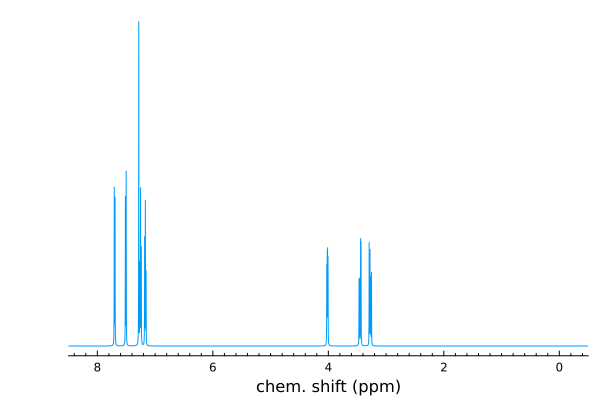

In [126]:
using Plots
Plots.plot(range(-0.5/δt,stop=0.5/δt,length=length(fid))/600.0.+4.78, 
            real.(fftshift(fft(fid))),
            xaxis=:flip,
            minorticks=10,
            xlabel="chem. shift (ppm)",
            xlims=[-0.5,8.5],
            yaxis=false,
            grid=false,
            legend=false,
        )